# Matchup satellite data to ship, glider, or animal tracks

<span style="color:#555">__History__<br>Created Apr 2024 by JP Sevadjian, based on latest CoastWatch satellite course examples, largely
https://github.com/coastwatch-training/CoastWatch-Tutorials/blob/main/matchup-satellite-data-to-track-locations/Python/matchup-satellite-data-to-track-locations.ipynb</span>

***

## Overview
In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there may be more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- A glider track that has been subsampled to reduce the data requests needed for this tutorial. The request for the glider track data can be adjusted.


### Python packages used:
* pandas | reading and analyzing data
* numpy | data analysis, manipulation
* xarray | multi-dimensional data analysis, manipulation
* matplotlib | mapping 
* cartopy | mapping 
* datetime | date manipulation

## Import the required Python modules

In [474]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
import requests
import io
import time
from urllib.parse import quote
import datetime
from geopy.distance import geodesic

warnings.filterwarnings('ignore')

# Preview the glider data metadata

Access information about the dataset from the server before attempting to make downloads.

In [475]:
gd_url = 'https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90'
gd_ds = xr.open_dataset(gd_url)
gd_ds

<xarray.Dataset>
Dimensions:         (s: 55790)
Dimensions without coordinates: s
Data variables: (12/17)
    s.profile       (s) int32 ...
    s.mission       (s) int32 ...
    s.depth         (s) float64 ...
    s.time          (s) datetime64[ns] ...
    s.latitude      (s) float64 ...
    s.longitude     (s) float64 ...
    ...              ...
    s.v             (s) float64 ...
    s.time_uv       (s) datetime64[ns] ...
    s.lat_uv        (s) float64 ...
    s.lon_uv        (s) float64 ...
    s.u_depth_mean  (s) float64 ...
    s.v_depth_mean  (s) float64 ...
Attributes: (12/64)
    _NCProperties:                   version=2,netcdf=4.8.1,hdf5=1.12.1
    acknowledgement:                 Funded by National Oceanic and Atmospher...
    acknowledgment:                  Funded by National Oceanic and Atmospher...
    cdm_data_type:                   TrajectoryProfile
    cdm_profile_variables:           time_uv,lat_uv,lon_uv,u_depth_mean,v_dep...
    cdm_trajectory_variables:        mission
    ...                              ...
    subsetVariables:                 mission
    summary:                         The overarching goal of the California U...
    time_coverage_end:               2023-07-11T16:35:50Z
    time_coverage_start:             2006-10-19T17:51:00Z
    title:                           California Underwater Glider Network - L...
    Westernmost_Easting:             -122.6719425

## Load the glider data into a Pandas data frame
Load the track data using the Pandas "read_csv" method. Then use the ".head()" method to view the column names and the first few rows of data. 

### Get the glider data as a csv file

The url specifies the following:

* The dataset and the output format
  * binnedCUGN90.csv
* The output parameters
  * profile%2Cmission%2Cdepth%2Ctime%2Clatitude%2Clongitude%2Ctemperature%2Cchlorophyll
* The constraints
  * &mission=29&depth%3E=10&depth%3C=10&orderByClosest("time/1day") 
  * Here mission index 29 is selected because it spans the spring of 2014. 
  * Only requesting the top bin where depth=10m
  * Reduce glider data to one value a day for testing using the <b>orderByClosest("time/1day")</b> option. See https://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html#functions for details on server-side function options.

In [476]:
# Request for every profile (about 1000)

mission_idx = '29'

gd_csv_all_url = ''.join(['https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90.csv?',
                    'profile%2Cmission%2Cdepth%2Ctime%2Clatitude%2Clongitude%2Ctemperature%2Cchlorophyll',
                    '&mission=',mission_idx,'&depth%3E=10&depth%3C=10'
                    ])

# adds orderbyclosest() to reduce request to daily for testing 
# result is about 100 points instead of 1000
gd_csv_daily_url = ''.join(['https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90.csv?',
                    'profile%2Cmission%2Cdepth%2Ctime%2Clatitude%2Clongitude%2Ctemperature%2Cchlorophyll',
                    '&mission=',mission_idx,'&depth%3E=10&depth%3C=10&orderByClosest("time/1day")'
                    ])
print(gd_csv_daily_url)

req = requests.get(gd_csv_daily_url).content

df = pd.read_csv(io.StringIO(req.decode('utf-8')), skiprows=[1])#, parse_dates=['time'])

df.head(8)


https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90.csv?profile%2Cmission%2Cdepth%2Ctime%2Clatitude%2Clongitude%2Ctemperature%2Cchlorophyll&mission=29&depth%3E=10&depth%3C=10&orderByClosest("time/1day")


,profile,mission,depth,time,latitude,longitude,temperature,chlorophyll
0,23117,29,10.0,2014-02-10T23:38:50Z,33.157027,-117.449403,15.644444,0.059133
1,23127,29,10.0,2014-02-12T00:09:30Z,33.104260,-117.525362,15.475900,0.059040
2,23135,29,10.0,2014-02-12T23:30:50Z,33.166025,-117.581265,15.441583,0.031300
3,23144,29,10.0,2014-02-14T01:16:58Z,33.222960,-117.686705,15.569727,0.043582
4,23152,29,10.0,2014-02-15T00:31:00Z,33.293555,-117.848190,15.276818,0.084545
5,23160,29,10.0,2014-02-15T23:45:47Z,33.324075,-118.061347,15.699583,0.037200
6,23171,29,10.0,2014-02-17T00:00:13Z,33.243335,-118.297552,14.644600,0.163440
7,23180,29,10.0,2014-02-18T00:25:21Z,33.163860,-118.514460,16.033538,0.042692


## Plot the track on a map

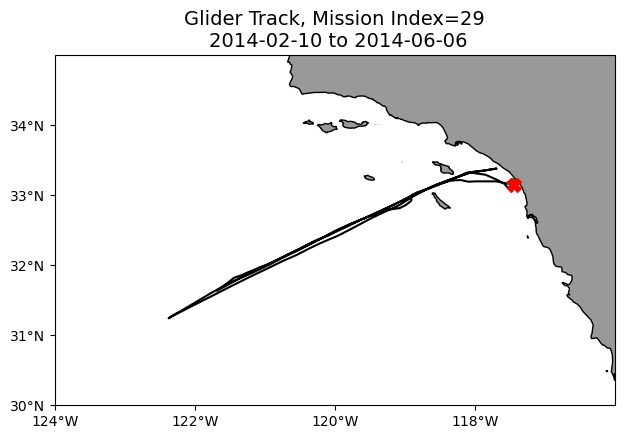

In [477]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 130:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=130))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([236, 244, 30, 35], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(236, 244, 2), crs=ccrs.PlateCarree())
ax1.set_yticks(range(30, 35, 1), crs=ccrs.PlateCarree())

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df.longitude.to_numpy(), df.latitude.to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')

# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
subtitle_text = df['time'][0][0:10] +' to '+ df['time'][df.index[-1]][0:10]
title='Glider Track, Mission Index='+ mission_idx +'\n '+ subtitle_text
plt.title(title, fontsize=14)

plt.show()

## Extract data from a satellite dataset corresponding to glider profile locations

We are going to download data from an ERDDAP server using the following steps: 
* Select a satellite dataset on an ERDDAP server
* Loop though the glider data frame and pull out the in-situ date, latitude and longitude coordinates from each row 
* Use these coordinates to request and download satellite data corresponding to the coordinates. 
* Store the satellite data in a temporary Pandas data frame
* Once all the satellite data has been added to the temporary data frame, merge it with the glider data frame.

### Select a satellite dataset
We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product that blends data from many ocean color sensors to create a long time series (1997-present) with better spatial coverage than any single sensor.


###  View the satellite data metadata
* Use the ERDDAP URL with no extension (e.g. without .html or .graph...). This is the OPeNDAP URL, which allows viewing  the dataset metadata
* Use the Xarray "open_dataset" function to view the metadata

In [478]:
cci_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily'

ds = xr.open_dataset(cci_url)

# Display satellite dataset metadata, takes a second, PML server is slow
ds

<xarray.Dataset>
Dimensions:             (time: 9589, latitude: 4320, longitude: 8640)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2023-12-31
  * latitude            (latitude) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * longitude           (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables: (12/93)
    MERIS_nobs          (time, latitude, longitude) float32 ...
    MODISA_nobs         (time, latitude, longitude) float32 ...
    OLCI_A_nobs         (time, latitude, longitude) float32 ...
    OLCI_B_nobs         (time, latitude, longitude) float32 ...
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_412_bias        (time, latitude, longitude) float32 ...
    ...                  ...
    water_class4        (time, latitude, longitude) float32 ...
    water_class5        (time, latitude, longitude) float32 ...
    water_class6        (time, latitude, longitude) float32 ...
    water_class7        (time, latitude, longitude) float32 ...
    water_class8        (time, latitude, longitude) float32 ...
    water_class9        (time, latitude, longitude) float32 ...
Attributes: (12/51)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     20240117T042504Z
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2023-12-31T00:00:00Z
    time_coverage_resolution:          P1D
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             ESA CCI Ocean Colour Product (CCI ALL-...
    tracking_id:                       ade092d1-55b0-4e6a-bac5-c96b7c4eed03
    Westernmost_Easting:               -179.97916666666666

__Useful Information found in the Metadata__
* The spatial and temporal resolution
* nobs variables will show us how many satellite values are included in the matched up cells. We will want to look at these in our analysis and may include in our matchup decision making if useful.

__Opening the dataset in Xarray lets you look at the dataset metadata.__   
* The metadata are listed above.
* No data is downloaded until you request it.  

__From the metadata you can view:__ 
* The coordinates (time, latitude and longitude) that you will use to select the data to download.
* A list of ten data variables. For this exercise, we want the "chlor_a" variable. If you want, you can find out about each variable with clicking the page icon to the right of each variable name. 

__A note on dataset selection__  
When selecting datasets on your own, check out the dataset to determine if its spatial and temporal coverages are suitable for your application. You can find that information above by clicking the right arrow next to "Attribute". Then look through the list to find: 
* 'time_coverage_start' and 'time_coverage_end': the time range
* 'geospatial_lat_min' and 'geospatial_lat_max': the latitude range
* 'geospatial_lon_min' and 'geospatial_lon_max': the longitude range

There are a lot of metadata attributes to look through. We can make it easier with a little code to print out the metadata of interest. Then compare these ranges to those found in your track data.


In [479]:
print('Satellite Data:')
print('  Time Range: ', ds.attrs['time_coverage_start'], 
      ds.attrs['time_coverage_end'])
print('  Latitude Range: ', ds.attrs['geospatial_lat_min'], 
      ds.attrs['geospatial_lat_max'])
print('  Longitude Range: ', ds.attrs['geospatial_lon_min'], 
      ds.attrs['geospatial_lon_max'])

print(' ')

print('Glider Data:')
print('  Time Range: ', df.time.min(), df.time.max())
print('  Latitude Range: ', 
      round(df.latitude.min(), 2), round(df.latitude.max(), 2))
print('  Longitude Range: ', 
      round(df.longitude.min(), 2), round(df.longitude.max(), 2))


Satellite Data:
  Time Range:  1997-09-04T00:00:00Z 2023-12-31T00:00:00Z
  Latitude Range:  -89.97916666666666 89.97916666666667
  Longitude Range:  -179.97916666666666 179.97916666666663
 
Glider Data:
  Time Range:  2014-02-10T23:38:50Z 2014-06-06T17:42:11Z
  Latitude Range:  31.24 33.38
  Longitude Range:  -122.37 -117.45


## CSV Data Access Example

* Make csv data requests for the satellite data and make the matchups. 

* This example builds off the CoastWatch example to specify padding around the glider point in time and space and to filter nan values.

* A good first test will be to pull a grid of satellite data around the glider point and plot it with the location of the glider

### Create the satellite request main url

In [480]:
# create variables for the unchanging parts of the ERDDAP data-request URL.   
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/'
dataset_id = "pmlEsaCCI60OceanColorDaily"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])

In [481]:
def is_unique(s):
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()



### Set the Thresholds for the Matchups

* Note CCI is coarser in temporal and spatial resolution than glider data, we will want all data points within range
* For the spatial thresholds, start with a threshold where we regularly are able to get a chl value.
  * Tried 0.1 which seemed a little to inclusive.
  * Reductions at 0.01 increment have impact on num of returns with data
* For reference, the number of satellite data cells returned at these thresholds:
  * 72 cells @ .1  |  50 cells at 0.09  |  32 cells at 0.07

In [482]:
time_thres = datetime.timedelta(days = 0.5) 
lat_thres = 0.1
lon_thres = 0.1 

### Get Matchups
* Make requests for satellite data
* Filter the matchup
* Create dataframe for all the satellite matchup data

* For each row in the glider data frame
* Create the query part of the ERDDAP data-request URL,
* Filter through the satellite data to find the closest/best matchup
* Add satellite matchup info to the glider data frame

In [483]:
#for testing crop the df to x rows.
#df=df[0:29]

sat_start = datetime.datetime.now()

col_names = ["cci_time", "matched_lat", "matched_lon", "matched_chla", "sp_dist"]

sat_df = pd.DataFrame(columns=col_names)
    
for i in range(0, len(df)):
    
    print(i+1, 'of', len(df))
    
    # Use glider profile information to form the satellite data request
    
    # Glider point datetime
    g_datetime = datetime.datetime.strptime(df['time'][i], "%Y-%m-%dT%H:%M:%SZ")

    # Datetimes for the request 
    timemin_dt = g_datetime - time_thres
    timemax_dt = g_datetime + time_thres
    
    # String format for request
    timemin = timemin_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    timemax = timemax_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Spatial bounds for the request
    latmin = str(df['latitude'][i] - lat_thres)
    latmax = str(df['latitude'][i] + lat_thres)
    lonmin = str(df['longitude'][i] - lon_thres)
    lonmax = str(df['longitude'][i] + lon_thres)
    
    query_url = ''.join([
                         '[(' + timemin + '):1:(' + timemax + ')]',
                         '[(' + latmin + '):1:(' + latmax + ')]', 
                         '[(' + lonmin + '):1:(' + lonmax + ')]'
                         ])
    
    encoded_query = quote(query_url, safe='')

    # In production, record this url as a column and store it with the data.
    print(start_url + query_url)

    url = start_url + encoded_query

    # Download the data as a CSV file directly into Pandas
    # csv is not saved to machine
    # The CCI Dataset is ultimately hosted on an ESA server 
    # which appears to be painfully slow
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names[0:4]
    
    print('Number of cells returned in search radius: ' +str(len(new)))
    
    
    if new['matched_chla'].isnull().all():
        print('** No valid satellite matches within search area')
        empty_row = new.loc[0]
        empty_row['matched_lat'] = ''
        empty_row['matched_lon'] = ''
        sat_df = pd.concat([sat_df, empty_row], ignore_index=True)
    else:
        print('* Found some data within initial constraints, finding best match...')
        
        # NAN FILTER
        # First, filter out matches without chl values, false returns
        # Reasons for no satellite chl include land and clouds
        new = new.loc[new['matched_chla'].notnull()]
        new = new.reset_index(drop=True)
        
        # TIME FILTER
        # Sometimes more than one time is returned.
        # If more than one time is returned, filter to only use the closest
        # Chlorophyll is daily and highly variable per day
        # It would be reasonable to test impact of filtering time first or location first.
        
        if not is_unique(new['cci_time']):
            
            # find closest time
            cci_datetimes=[]
            for j in range(0, len(new)):
                cci_datetimes.append(datetime.datetime.strptime(new['cci_time'].iloc[j], "%Y-%m-%dT%H:%M:%SZ"))
                         
            # filter to closest timestamp
            time_diffs = [abs(g_datetime-item) for item in cci_datetimes]
            which_time_diffs = [i for i,v in enumerate(time_diffs) if v == min(time_diffs)]
            new = new.loc[which_time_diffs]
        

        # DISTANCE FILTER
        # Calculate spatial distances
        
        glider_loc = (df['latitude'][i], df['longitude'][i])
        dists = []
        for j in range(0, len(new)):
            satellite_loc = (new['matched_lat'].iloc[j], new['matched_lon'].iloc[j])
            dist = geodesic(glider_loc, satellite_loc).km
            dists.append(dist)
            
        new['sp_dist'] = dists
        
        
        # Filter to closest cell
        new = new.loc[new['sp_dist'] == min(dists)]

        if len(new)>1:
            print('ERROR: Multiple rows, only one allowed. Number of rows: ' + str(len(new)))
            break
        # new df should be a single row now.
        # Note: This may not be the best matchup choice, need to make plots/analyze
        
        # Add the matchup to the full df
        sat_df = pd.concat([sat_df, new], ignore_index=True)
    

    # Give server a little break before the next request
    time.sleep(2)

time_to_process = datetime.datetime.now() - sat_start
print(time_to_process)

1 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-10T11:38:50Z):1:(2014-02-11T11:38:50Z)][(33.0570275):1:(33.2570275)][(-117.5494025):1:(-117.34940250000001)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
2 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-11T12:09:30Z):1:(2014-02-12T12:09:30Z)][(33.004259999999995):1:(33.20426)][(-117.6253625):1:(-117.4253625)]
Number of cells returned in search radius: 60
* Found some data within initial constraints, finding best match...
3 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-12T11:30:50Z):1:(2014-02-13T11:30:50Z)][(33.066025):1:(33.266025000000006)][(-117.681265):1:(-117.48126500000001)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
4 of 117
ht

Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
27 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-08T11:52:50Z):1:(2014-03-09T11:52:50Z)][(31.309672499999998):1:(31.5096725)][(-122.194285):1:(-121.994285)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
28 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-09T11:54:21Z):1:(2014-03-10T11:54:21Z)][(31.245575):1:(31.445575)][(-122.30219):1:(-122.10219000000001)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
29 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-10T11:53:20Z):1:(2014-03-11T11:53:20Z)][(31.1909875):1:(31.3909875)][(-122.4004075):1:(-122.20040750000001)]
Number of cells re

52 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-02T13:31:07Z):1:(2014-04-03T13:31:07Z)][(33.0603925):1:(33.2603925)][(-118.589755):1:(-118.38975500000001)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
53 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-03T11:43:50Z):1:(2014-04-04T11:43:50Z)][(33.1375225):1:(33.337522500000006)][(-118.39742249999999):1:(-118.1974225)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
54 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-04T11:00:14Z):1:(2014-04-05T11:00:14Z)][(33.222355):1:(33.422355)][(-118.21813499999999):1:(-118.018135)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
55 of 117

Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
78 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-28T10:58:24Z):1:(2014-04-29T10:58:24Z)][(31.7220175):1:(31.922017500000003)][(-121.53966111924686):1:(-121.33966111924687)]
Number of cells returned in search radius: 60
* Found some data within initial constraints, finding best match...
79 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-29T13:28:38Z):1:(2014-04-30T13:28:38Z)][(31.759445):1:(31.959445000000002)][(-121.4288):1:(-121.2288)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
80 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-04-30T12:10:03Z):1:(2014-05-01T12:10:03Z)][(31.8002625):1:(32.0002625)][(-121.3410225):1:(-121.1410225)]
Number of c

103 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-05-23T11:15:17Z):1:(2014-05-24T11:15:17Z)][(32.940352499999996):1:(33.1403525)][(-118.9272175):1:(-118.72721750000001)]
Number of cells returned in search radius: 72
** No valid satellite matches within search area
104 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-05-24T13:18:31Z):1:(2014-05-25T13:18:31Z)][(32.975649999999995):1:(33.17565)][(-118.81768749999999):1:(-118.6176875)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
105 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-05-25T13:39:56Z):1:(2014-05-26T13:39:56Z)][(33.022405):1:(33.222405)][(-118.7131675):1:(-118.51316750000001)]
Number of cells returned in search radius: 72
* Found some data within initial constraints, finding best match...
106 of 117
https:

### Add the satellite data to the glider data frame

* This code is from the CW example. If this becomes inconvenient, consider the option to populate by index. This would require tracking the corresponding indices above.

In [484]:
df[['matched_lat', 
    'matched_lon', 
    'matched_chla', 
    'cci_time',
    'sp_dist']] = sat_df[['matched_lat',
                        'matched_lon',
                        'matched_chla',
                        'cci_time',
                        'sp_dist']]
df


,profile,mission,depth,time,latitude,longitude,temperature,chlorophyll,matched_lat,matched_lon,matched_chla,cci_time,sp_dist
0,23117,29,10.0,2014-02-10T23:38:50Z,33.157027,-117.449403,15.644444,0.059133,33.187500,-117.437500,1.197089,2014-02-10T00:00:00Z,3.557296
1,23127,29,10.0,2014-02-12T00:09:30Z,33.104260,-117.525362,15.475900,0.059040,33.104167,-117.520833,0.327330,2014-02-12T00:00:00Z,0.422894
2,23135,29,10.0,2014-02-12T23:30:50Z,33.166025,-117.581265,15.441583,0.031300,33.145833,-117.562500,0.338082,2014-02-13T00:00:00Z,2.842424
3,23144,29,10.0,2014-02-14T01:16:58Z,33.222960,-117.686705,15.569727,0.043582,33.145833,-117.604167,0.313484,2014-02-14T00:00:00Z,11.507377
4,23152,29,10.0,2014-02-15T00:31:00Z,33.293555,-117.848190,15.276818,0.084545,33.229167,-117.770833,0.326830,2014-02-15T00:00:00Z,10.146449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,24013,29,10.0,2014-06-02T22:36:00Z,33.199150,-117.973853,18.740667,0.015900,NaN,NaN,NaN,NaN,NaN
113,24021,29,10.0,2014-06-03T23:13:40Z,33.198723,-117.825622,18.275636,0.014127,NaN,NaN,NaN,NaN,NaN
114,24029,29,10.0,2014-06-04T23:53:27Z,33.198492,-117.694112,18.502182,0.015982,NaN,NaN,NaN,NaN,NaN
115,24040,29,10.0,2014-06-05T23:27:26Z,33.167178,-117.533978,18.591800,0.017040,NaN,NaN,NaN,NaN,NaN


In [485]:
sat_df.head(20)

,cci_time,matched_lat,matched_lon,matched_chla,sp_dist,0
0,2014-02-10T00:00:00Z,33.187500,-117.437500,1.197089,3.557296,NaN
1,2014-02-12T00:00:00Z,33.104167,-117.520833,0.327330,0.422894,NaN
2,2014-02-13T00:00:00Z,33.145833,-117.562500,0.338082,2.842424,NaN
3,2014-02-14T00:00:00Z,33.145833,-117.604167,0.313484,11.507377,NaN
4,2014-02-15T00:00:00Z,33.229167,-117.770833,0.326830,10.146449,NaN
5,2014-02-16T00:00:00Z,33.312500,-118.062500,0.270791,1.288262,NaN
6,NaN,NaN,NaN,NaN,NaN,2014-02-17T00:00:00Z
7,NaN,NaN,NaN,NaN,NaN,
8,NaN,NaN,NaN,NaN,NaN,
9,NaN,NaN,NaN,NaN,NaN,NaN


In [486]:
df.head(20)

,profile,mission,depth,time,latitude,longitude,temperature,chlorophyll,matched_lat,matched_lon,matched_chla,cci_time,sp_dist
0,23117,29,10.0,2014-02-10T23:38:50Z,33.157027,-117.449403,15.644444,0.059133,33.187500,-117.437500,1.197089,2014-02-10T00:00:00Z,3.557296
1,23127,29,10.0,2014-02-12T00:09:30Z,33.104260,-117.525362,15.475900,0.059040,33.104167,-117.520833,0.327330,2014-02-12T00:00:00Z,0.422894
2,23135,29,10.0,2014-02-12T23:30:50Z,33.166025,-117.581265,15.441583,0.031300,33.145833,-117.562500,0.338082,2014-02-13T00:00:00Z,2.842424
3,23144,29,10.0,2014-02-14T01:16:58Z,33.222960,-117.686705,15.569727,0.043582,33.145833,-117.604167,0.313484,2014-02-14T00:00:00Z,11.507377
4,23152,29,10.0,2014-02-15T00:31:00Z,33.293555,-117.848190,15.276818,0.084545,33.229167,-117.770833,0.326830,2014-02-15T00:00:00Z,10.146449
5,23160,29,10.0,2014-02-15T23:45:47Z,33.324075,-118.061347,15.699583,0.037200,33.312500,-118.062500,0.270791,2014-02-16T00:00:00Z,1.288262
6,23171,29,10.0,2014-02-17T00:00:13Z,33.243335,-118.297552,14.644600,0.163440,NaN,NaN,NaN,NaN,NaN
7,23180,29,10.0,2014-02-18T00:25:21Z,33.163860,-118.514460,16.033538,0.042692,NaN,NaN,NaN,NaN,NaN
8,23188,29,10.0,2014-02-18T22:53:24Z,33.076992,-118.716930,15.563700,0.035580,NaN,NaN,NaN,NaN,NaN
9,23197,29,10.0,2014-02-20T00:20:29Z,32.981272,-118.927612,14.653273,0.244364,NaN,NaN,NaN,NaN,NaN


### Save your work
* Create a unique id to save this data
* Could add the thesholds to the filename or to add a header to the csv

In [487]:
run_id = mission_idx +'_'+ datetime.datetime.now().strftime("%Y%m%d_%H%M")
print(run_id)

29_20240503_1330


In [488]:
print(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M"))
out_fn = ''.join(['chl_matchup_',run_id,  '.csv'])
print(out_fn)
df.to_csv(out_fn, index=False, encoding='utf-8')

2024_05_03_13_30
chl_matchup_29_20240503_1330.csv


## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.10308955 1.4165946


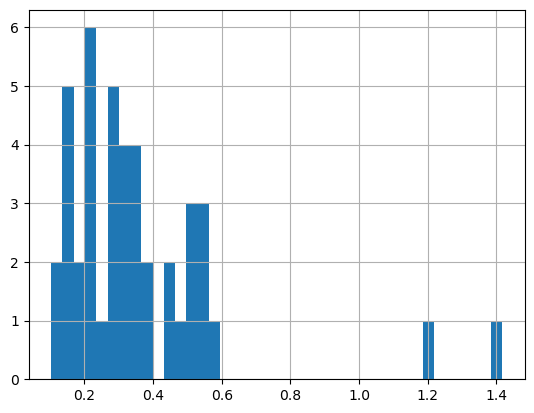

In [489]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values and a few very high values. Using a  linear color bar,  most of the lower values would have the same color.
* To better visualize the data, we often plot the log or log10 of chlorophyll. 

### Plot a histogram of the log of the chlorophyll data

Range: -2.272157251001229 0.34825582238602826


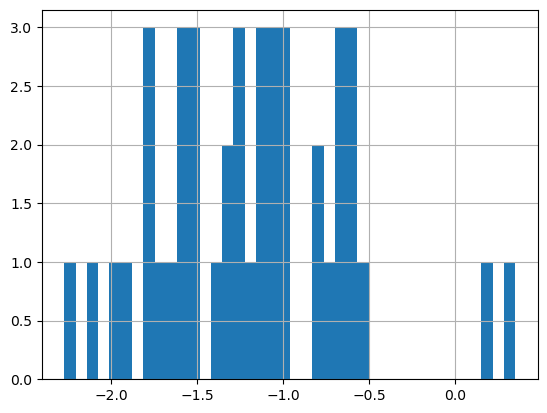

In [490]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The logarithmic transformation displays the range of values across the color bar range (above). 

### Map the chlorophyll data
This plot is not very insightful for our use case. Timeseries and scatter plots found in other tutorials would be better. Here is a notebook with more useful types of plots: 
https://github.com/coastwatch-training/CoastWatch-Tutorials/blob/main/create-virtual-buoy-with-satellite-data/Python/create-virtual-buoy-with-satellite-data.ipynb

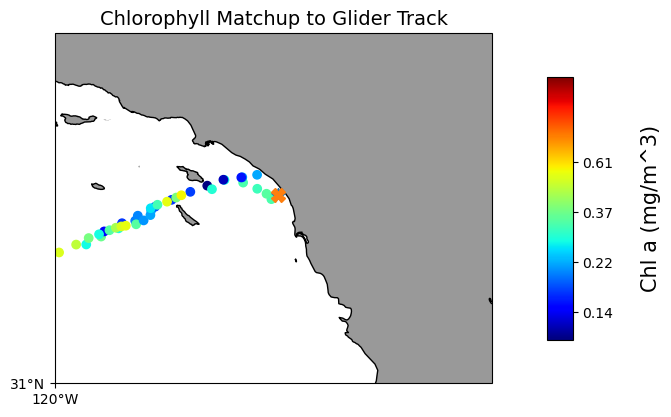

In [491]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([240,245, 31, 35], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(240,245,10), crs=ccrs.PlateCarree())
ax1.set_yticks(range(31,35,5), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df.longitude),list(df.latitude)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)

# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Glider Track", size=14)
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the NOAA Geo-polar Blended Analysis SST, GHRSST dataset:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5NRT_Lon0360.html  
* This dataset is a different ERDDAP; It has a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset.   


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 

##### Optional
Repeat the steps above with a daily version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


### Xarray Access Example

##For reference only. Not used.

You can download the data using the opendap connection instead of accessing via csv file. There are advantages to this method especially when working with bigger datasets. However the matchup function demo here is not sophisticated enough for our needs. We need more control over the selection of the matchup. The csv method above is more transparent and easy to follow. We could test xarray against the csv results if there is interest, but it is not needed.

In [493]:
# Xarray access demo
# This method looks only for the nearest point
# Need ability to specify multiple thresholds on the selection, not super useful as-is

xcol_names = ["erddap_date", "matched_lat", "matched_lon", "matched_chla"]

xtot = pd.DataFrame(columns=xcol_names)

# For each point on the in-situ data track
# Find the nearest satellite data point
# Request the satellite data
# Add satellite data to a new pandas data frame
# Finish each URL and download

for i in range(0, 4):# len(df)):
    clear_output(wait=True)
    print(i+1, 'of', len(df))
    
    # Use opendap to extract the data at the point of interest
    # Find the parts of the satellite dataset to include 
    # Selection corresponds to glider locations
    cropped_ds = ds['chlor_a'].sel(time=df.time[i][0:10],
                                   latitude=df.latitude[i],
                                   longitude=df.longitude[i],
                                   method='nearest'
                                   )
     
    # Download the data and add it to a new line in the tot data frame
    xtot.loc[len(tot.index)] = [cropped_ds.time.values,
                               np.round(cropped_ds.latitude.values, 5),  # round 5 dec
                               np.round(cropped_ds.longitude.values, 5), # round 5 dec
                               np.round(cropped_ds.values, 2)  # round 2 decimals
                               ]
    
    
    time.sleep(2) # Be nice to the server and space out the requests

xtot

4 of 117


KeyboardInterrupt: 